# Case Study Walkthrough – Customer Value Intelligence System

This notebook walks through the final customer-level output:
- Segments from clustering
- 6-month CLV estimates
- Revenue concentration by segment and geography
- Example strategies for each segment


In [4]:
# import os
# import sys
# from pathlib import Path


# # If this notebook is inside `notebooks/`, go one level up to project root
# project_root = Path(os.getcwd()).parent
# os.chdir(project_root)

# # Make sure root is on sys.path so `src` is importable
# sys.path.append(str(project_root))

# print("CWD:", os.getcwd())
# print("Project root on sys.path:", project_root)


# # get the project root (one level up from notebooks/)
# project_root = Path(os.getcwd()).parent
# sys.path.append(str(project_root))

# print("Project root added to sys.path:", project_root)


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (6, 4)

df = pd.read_csv("data/processed/rfm_segments.csv")
df.head()


,CustomerID,Recency,Frequency,Monetary,CatShare_Bags,CatShare_HomeDecor,CatShare_Kitchen,CatShare_Other,CatShare_Toys,PrimaryCountry,IsUK,CLV_6m,Cluster_KMeans,Cluster_Hierarchical,Cluster_GMM
0,12346.0,326,1,77183.60,0.000000,0.000000,0.000000,1.000000,0.000000,United Kingdom,1.0,NaN,1,2,3
1,12347.0,2,7,4310.00,0.110766,0.112278,0.050487,0.712548,0.013921,Iceland,0.0,1705.509633,3,3,1
2,12348.0,75,4,1797.24,0.000000,0.000000,0.000000,1.000000,0.000000,Finland,0.0,626.855620,3,3,1
3,12349.0,19,1,1757.55,0.007510,0.034082,0.078723,0.879685,0.000000,Italy,0.0,NaN,3,3,1
4,12350.0,310,1,334.40,0.061005,0.000000,0.000000,0.938995,0.000000,Norway,0.0,NaN,1,3,1


## 1. Summary of Processed Customer Data


In [5]:
df.shape, df["CustomerID"].nunique()


((4338, 15), 4338)

In [6]:
df[["Recency", "Frequency", "Monetary", "CLV_6m"]].describe()


,Recency,Frequency,Monetary,CLV_6m
count,4338.000000,4338.000000,4338.000000,2790.000000
mean,92.536422,4.272015,2048.688081,1495.803544
std,100.014169,7.697998,8985.230220,4705.172171
min,1.000000,1.000000,3.750000,55.950319
25%,18.000000,1.000000,306.482500,529.229407
50%,51.000000,2.000000,668.570000,834.419322
75%,142.000000,5.000000,1660.597500,1371.984387
max,374.000000,209.000000,280206.020000,124603.220474


In [8]:
cluster_cols = [c for c in df.columns if c.startswith("Cluster_")]
cluster_cols

['Cluster_KMeans', 'Cluster_Hierarchical', 'Cluster_GMM']

In [9]:
cluster_col = "Cluster_KMeans" if "Cluster_KMeans" in cluster_cols else cluster_cols[0]
cluster_col

'Cluster_KMeans'

## 2. Segment Summary (KPI View)


In [10]:
segment_summary = (
    df.groupby(cluster_col)
    .agg(
        Customers=("CustomerID", "nunique"),
        TotalRevenue=("Monetary", "sum"),
        AvgRecency=("Recency", "mean"),
        AvgFrequency=("Frequency", "mean"),
        AvgMonetary=("Monetary", "mean"),
        AvgCLV=("CLV_6m", "mean")
    )
    .reset_index()
    .sort_values("TotalRevenue", ascending=False)
)

segment_summary


,Cluster_KMeans,Customers,TotalRevenue,AvgRecency,AvgFrequency,AvgMonetary,AvgCLV
3,3,2971,7906701.433,40.350050,5.345338,2661.292976,1694.174470
1,1,998,665721.541,243.834669,1.607214,667.055652,422.609019
0,0,336,289508.870,98.497024,2.883929,861.633542,889.295224
2,2,33,25277.050,154.575758,2.363636,765.971212,651.238431


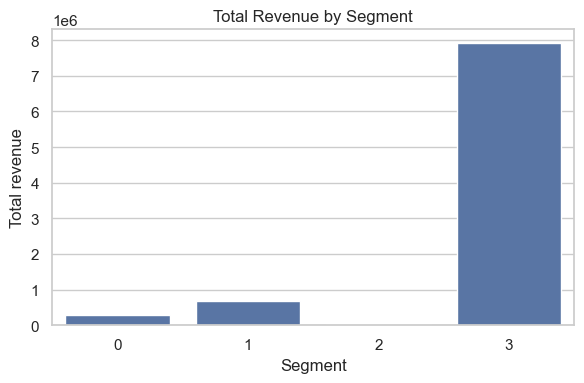

In [11]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(
    x=cluster_col,
    y="TotalRevenue",
    data=segment_summary,
    ax=ax
)
ax.set_title("Total Revenue by Segment")
ax.set_xlabel("Segment")
ax.set_ylabel("Total revenue")
plt.tight_layout()
plt.show()


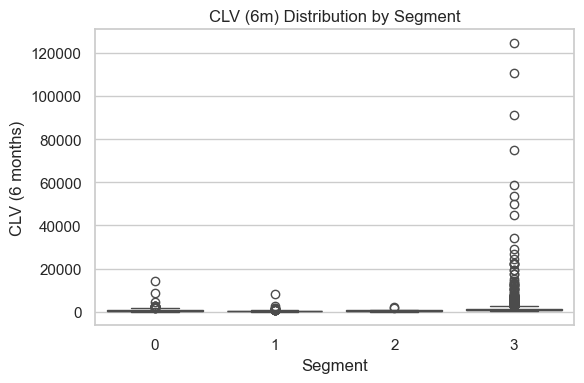

In [12]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(
    x=cluster_col,
    y="CLV_6m",
    data=df,
    ax=ax
)
ax.set_title("CLV (6m) Distribution by Segment")
ax.set_xlabel("Segment")
ax.set_ylabel("CLV (6 months)")
plt.tight_layout()
plt.show()


### Interpretation

- One or two segments contribute a disproportionately large share of total revenue (VIP clusters).
- These high-value segments also show higher average CLV, confirming their future importance.
- Lower-value segments show low CLV and low contribution to revenue, but may still have strategic use for growth or experimentation.


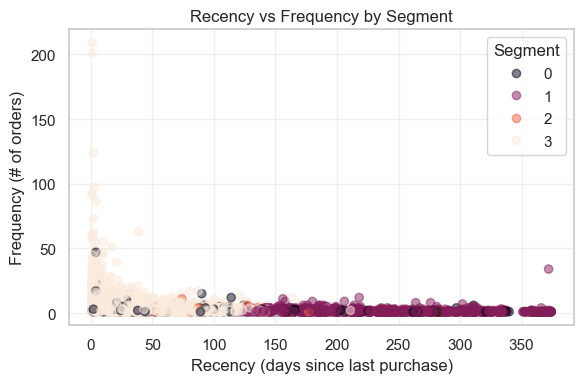

In [13]:
fig, ax = plt.subplots(figsize=(6, 4))
scatter = ax.scatter(
    df["Recency"],
    df["Frequency"],
    c=df[cluster_col],
    alpha=0.5
)
ax.set_title("Recency vs Frequency by Segment")
ax.set_xlabel("Recency (days since last purchase)")
ax.set_ylabel("Frequency (# of orders)")
plt.grid(alpha=0.3)

handles, labels = scatter.legend_elements()
ax.legend(handles, labels, title="Segment", loc="best")

plt.tight_layout()
plt.show()


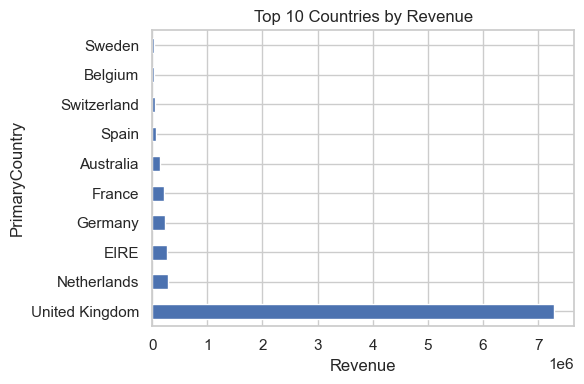

In [14]:
if "PrimaryCountry" in df.columns:
    country_rev = (
        df.groupby("PrimaryCountry")["Monetary"]
        .sum()
        .rename("Revenue")
        .reset_index()
        .sort_values("Revenue", ascending=False)
        .head(10)
    )

    country_rev
    country_rev.plot(kind="barh", x="PrimaryCountry", y="Revenue", legend=False)
    plt.title("Top 10 Countries by Revenue")
    plt.xlabel("Revenue")
    plt.tight_layout()
    plt.show()


## 3. Segment Playbooks (Mapping Clusters to Business Labels)

Using the segment metrics above, each cluster can be mapped to a business label such as:
- VIP Loyalists
- High-Potential Newcomers
- At-Risk Loyalists
- Discount-Driven Shoppers
- Dormant / One-and-Done

These mappings are documented in the README and the 1-page case study.


## 4. Summary

This notebook walks through:
- Final customer-level outputs (RFM, CLV, clusters)
- Segment-level KPIs (revenue, CLV, recency, frequency)
- Key visuals used in the case study and README

It can be used as a live walkthrough in interviews or internal demos to explain how the Customer Value Intelligence System works end-to-end.
